# RL Integ/Lead Design (11-7)

In [21]:
import requests as req,os
URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]
try:
    %run basic_material.py
    print('Basic file found')
except:    
    print('Basic files not` found - downloading it')
    for dfile in File:
        if not os.path.isfile(dfile):
            print(dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

import cmath #, sympy 
from sympy import Symbol, atan, pi, tan, sqrt, solve, log
from numpy.polynomial import Polynomial
from numpy import inf

from control.matlab import tf, rlocus, step, feedback, lsim, bode
from control import pade

from control_materials import *

def writefile(filename, Gc):
    with open(filename+"_zero.txt", "w") as f:
        f.write(str(f"{np.real(-Gc.zeros())[0]:4.3f}"))
    with open(filename+"_pole.txt", "w") as f:
        f.write(str(f"{np.real(-Gc.poles())[0]:4.3f}"))
    with open(filename+"_gain.txt", "w") as f:
        gain = Gc.num[0][0]/Gc.den[0][0]
        f.write(str(f"{gain[0]:4.2f}"))

Running Python: 3.12.6
Running Sympy: 1.13.2
Control Package Found
Basic file found


In [22]:
G = tf((0, 10), np.convolve((1,5),(1,10)))
# Goals
Mp = 0.2 # (1-zeta/0.6)
Ts = 1
zeta = np.sqrt(np.log(Mp)**2/(np.pi**2+np.log(Mp)**2))
#
wn = 4/zeta/Ts # 2%
sigma = zeta*wn
wd = wn*np.sqrt(1-zeta**2)
# Target Poles
s0 = np.roots([1, 2*zeta*wn, wn**2])

print("Target poles:", s0)
print(f"{zeta = :.3f}")
print(f"{wn = :.3f}")
print(f"{wd = :.3f}")
print(f"{sigma = :.3f}")

Target poles: [-4.+7.80792506j -4.-7.80792506j]
zeta = 0.456
wn = 8.773
wd = 7.808
sigma = 4.000


In [23]:
# Need an integrator for zero SS error to step
# gain 10 seems reasonable
Gc_int = 10*tf((1), (1, 0))
L_int = G*Gc_int
# Ramp error
Kv_req = 1/0.05


Found breakin/out at K = 0.481
At possible locations s = -2.113


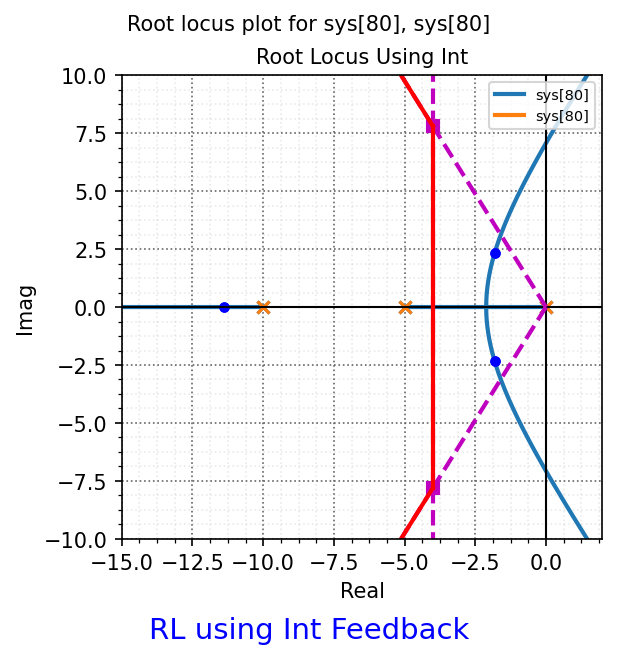

In [24]:
fig, ax = plt.subplots(figsize=(4, 4),dpi=150,constrained_layout = True)
rlocus(L_int,ax=ax,kvect=Root_Locus_gains(L_int),grid=False)
scl = rlocus(L_int,kvect=[1,1],grid=False)
ax.plot(s0.real,s0.imag,'ms',ms=6)
ax.plot(scl[0].real,scl[0].imag,'bo',ms=4)
ax.set_xlim([-15, 2])
ax.set_ylim([-10, 10])
ax.set_title('Root Locus Using Int')
ax.set_xlabel('Real')
ax.set_ylabel('Imag')
nicegrid(ax,-1)

plt.plot([-zeta*wn, -zeta*wn],[-wd, wd],'m--')
plt.plot([-zeta*wn, -zeta*wn],[wd, 20],'m--')
plt.plot([-zeta*wn, -zeta*wn],[-wd, -20],'m--')
th = np.arctan(wd/(zeta*wn))
plt.plot([-zeta*wn, -20],[zeta*wn*np.tan(th), 20*np.tan(th)],'m--')
plt.plot([-zeta*wn, -20],[-zeta*wn*np.tan(th), -20*np.tan(th)],'m--')
plt.plot([-0, -zeta*wn],[0, wd],'m--')
plt.plot([-0, -zeta*wn],[0, -wd],'m--')

plt.plot([-zeta*wn, -zeta*wn],[-wd, wd],'r-')
plt.plot([-zeta*wn, -20],[zeta*wn*np.tan(th), 20*np.tan(th)],'r-')
plt.plot([-zeta*wn, -20],[-zeta*wn*np.tan(th), -20*np.tan(th)],'r-')

caption("RL using Int Feedback",fig,yloc=-0.05)
savefig("./figs/L13_RL_des1.pdf", dpi=600)
plt.show()

In [25]:
# Add lead with zero at -4
Gc_lead, scl = Root_Locus_design_cancel(L_int,s_target = s0[0], s_cancel = -4)
Gain = np.squeeze(Gc_lead.num)[0]/np.squeeze(Gc_lead.den)[0]
print(f"{Gain = :.3f}")
print(f"{Gc_lead.zeros()[0] = :.3f}")
print(f"{Gc_lead.poles()[0] = :.3f}")

writefile(source+"Gc_11_09", Gc_lead)

Gc_lead

Gain = 22.351
Gc_lead.zeros()[0] = -4.000+0.000j
Gc_lead.poles()[0] = -28.447+0.000j


TransferFunction(array([  22.351,   89.403]), array([   1.000,   28.447]))

Current Kv = 6.286

Found breakin/out at K = 0.136
At possible locations s = -6.757


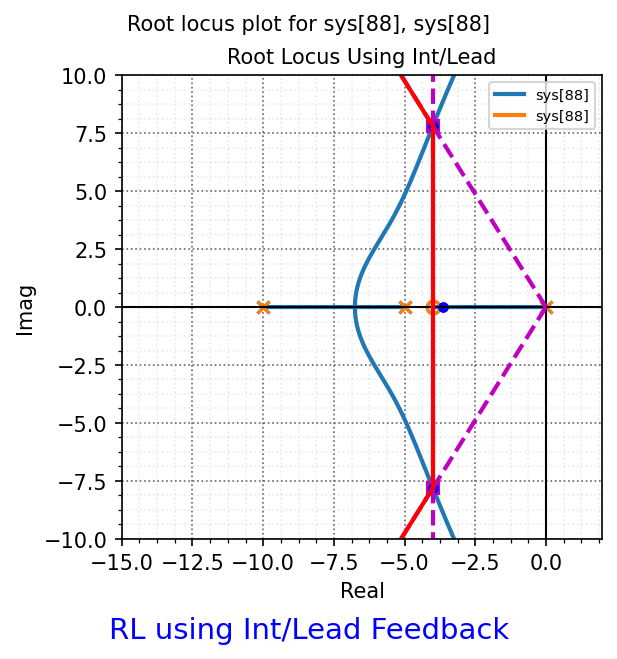

In [26]:
L_int_lead = G*Gc_int*Gc_lead
Kv = find_Kv(L_int_lead)

print(r'Current Kv = {:5.3f}'.format(Kv))

fig, ax = plt.subplots(figsize=(4, 4),dpi=150,constrained_layout = True)
rlocus(L_int_lead,ax=ax,kvect=Root_Locus_gains(L_int_lead),grid=False)
scl = rlocus(L_int_lead,kvect=[1,1],grid=False)
ax.plot(s0.real,s0.imag,'ms',ms=6)
ax.plot(scl[0].real,scl[0].imag,'bo',ms=4)
ax.set_xlim([-15, 2])
ax.set_ylim([-10, 10])
ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.set_title('Root Locus Using Int/Lead')
nicegrid(ax,-1)

plt.plot([-zeta*wn, -zeta*wn],[-wd, wd],'m--')
plt.plot([-zeta*wn, -zeta*wn],[wd, 20],'m--')
plt.plot([-zeta*wn, -zeta*wn],[-wd, -20],'m--')
th = np.arctan(wd/(zeta*wn))
plt.plot([-zeta*wn, -20],[zeta*wn*np.tan(th), 20*np.tan(th)],'m--')
plt.plot([-zeta*wn, -20],[-zeta*wn*np.tan(th), -20*np.tan(th)],'m--')
plt.plot([-0, -zeta*wn],[0, wd],'m--')
plt.plot([-0, -zeta*wn],[0, -wd],'m--')

plt.plot([-zeta*wn, -zeta*wn],[-wd, wd],'r-')
plt.plot([-zeta*wn, -20],[zeta*wn*np.tan(th), 20*np.tan(th)],'r-')
plt.plot([-zeta*wn, -20],[-zeta*wn*np.tan(th), -20*np.tan(th)],'r-')

caption("RL using Int/Lead Feedback",fig,yloc=-0.05)
savefig("./figs/L13_RL_des2.pdf", dpi=600)
plt.show()

In [27]:
# Pole locations good - Kv req met?
gamma = 10
b = abs(s0[0])/gamma
a = b / (Kv_req / Kv)
Gc_lag = tf((1, b), (1, a))

writefile(source+"Gc_11_11", Gc_lag)

Gc_lag

TransferFunction(array([   1.000,    0.877]), array([   1.000,    0.276]))


Found breakin/out at K = 0.149
At possible locations s = -6.706

Found breakin/out at K = 0.419
At possible locations s = -1.639

Found breakin/out at K = 0.004
At possible locations s = -0.150


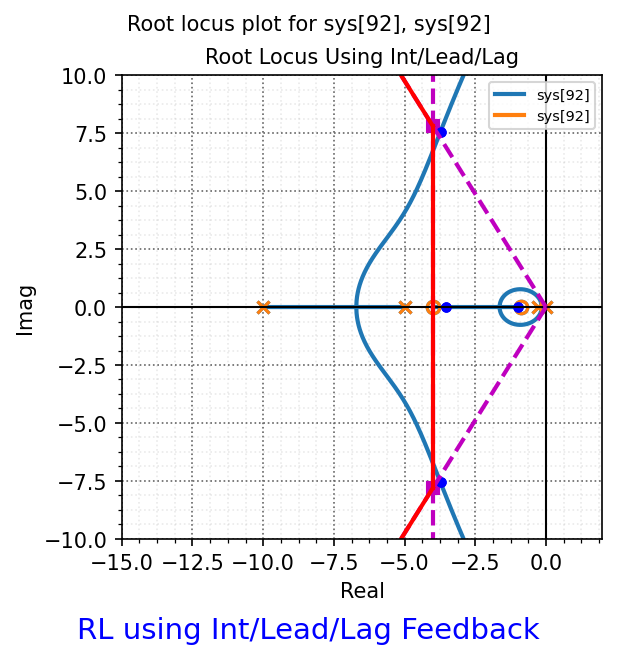

In [28]:
L_full = G*Gc_int*Gc_lead*Gc_lag

fig, ax = plt.subplots(figsize=(4, 4),dpi=150,constrained_layout = True)
rlocus(L_full,ax=ax,kvect=Root_Locus_gains(L_full),grid=False)
scl = rlocus(L_full,kvect=[1,1],grid=False)
ax.plot(s0.real,s0.imag,'ms',ms=6)
ax.plot(scl[0].real,scl[0].imag,'bo',ms=4)
ax.set_xlim([-15, 2])
ax.set_ylim([-10, 10])
ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.set_title('Root Locus Using Int/Lead/Lag')
nicegrid(ax)

plt.plot([-zeta*wn, -zeta*wn],[-wd, wd],'m--')
plt.plot([-zeta*wn, -zeta*wn],[wd, 20],'m--')
plt.plot([-zeta*wn, -zeta*wn],[-wd, -20],'m--')
th = np.arctan(wd/(zeta*wn))
plt.plot([-zeta*wn, -20],[zeta*wn*np.tan(th), 20*np.tan(th)],'m--')
plt.plot([-zeta*wn, -20],[-zeta*wn*np.tan(th), -20*np.tan(th)],'m--')
plt.plot([-0, -zeta*wn],[0, wd],'m--')
plt.plot([-0, -zeta*wn],[0, -wd],'m--')

plt.plot([-zeta*wn, -zeta*wn],[-wd, wd],'r-')
plt.plot([-zeta*wn, -20],[zeta*wn*np.tan(th), 20*np.tan(th)],'r-')
plt.plot([-zeta*wn, -20],[-zeta*wn*np.tan(th), -20*np.tan(th)],'r-')

caption("RL using Int/Lead/Lag Feedback",fig,yloc=-0.05)
savefig("./figs/L13_RL_des3.pdf", dpi=600)
plt.show()

## Since adding Lag impacted closed-loop poles locations, redesign Lead to compensate for this Lag effect

Gain = 28.894
Gc_lead2.zeros()[0] = -4.000+0.000j
Gc_lead2.poles()[0] = -35.291+0.000j
Current Kv = 20.841

Found breakin/out at K = 0.152
At possible locations s = -6.742

Found breakin/out at K = 0.407
At possible locations s = -1.631

Found breakin/out at K = 0.004
At possible locations s = -0.150


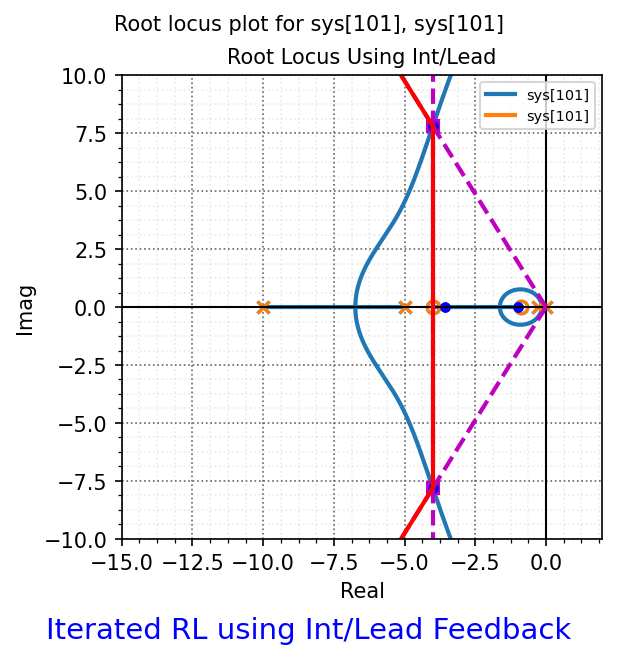

In [29]:
## Add lead with zero at -4
# now we dsign the lead including the lag compensator   
L_iter = G*Gc_int*Gc_lag
Gc_lead2, scl2 = Root_Locus_design_cancel(L_iter,s_target = s0[0], s_cancel = -4)
Gain = np.squeeze(Gc_lead2.num)[0]/np.squeeze(Gc_lead2.den)[0]
print(f"{Gain = :.3f}")
print(f"{Gc_lead2.zeros()[0] = :.3f}")
print(f"{Gc_lead2.poles()[0] = :.3f}")

L_full2 = L_iter*Gc_lead2
Kv_full2 = find_Kv(L_full2)
print(r'Current Kv = {:5.3f}'.format(Kv_full2))

fig, ax = plt.subplots(figsize=(4, 4),dpi=150,constrained_layout = True)
rlocus(L_full2,ax=ax,kvect=Root_Locus_gains(L_full2),grid=False)
scl2 = rlocus(L_full2,kvect=[1,1],grid=False)
ax.plot(s0.real,s0.imag,'ms',ms=6)
ax.plot(scl2[0].real,scl2[0].imag,'bo',ms=4)
ax.set_xlim([-15, 2])
ax.set_ylim([-10, 10])
ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.set_title('Root Locus Using Int/Lead')
nicegrid(ax,-1)

plt.plot([-zeta*wn, -zeta*wn],[-wd, wd],'m--')
plt.plot([-zeta*wn, -zeta*wn],[wd, 20],'m--')
plt.plot([-zeta*wn, -zeta*wn],[-wd, -20],'m--')
th = np.arctan(wd/(zeta*wn))
plt.plot([-zeta*wn, -20],[zeta*wn*np.tan(th), 20*np.tan(th)],'m--')
plt.plot([-zeta*wn, -20],[-zeta*wn*np.tan(th), -20*np.tan(th)],'m--')
plt.plot([-0, -zeta*wn],[0, wd],'m--')
plt.plot([-0, -zeta*wn],[0, -wd],'m--')

plt.plot([-zeta*wn, -zeta*wn],[-wd, wd],'r-')
plt.plot([-zeta*wn, -20],[zeta*wn*np.tan(th), 20*np.tan(th)],'r-')
plt.plot([-zeta*wn, -20],[-zeta*wn*np.tan(th), -20*np.tan(th)],'r-')

caption("Iterated RL using Int/Lead Feedback",fig,yloc=-0.05)
savefig("./figs/L13_RL_des2_iter.pdf", dpi=600)
plt.show()

Using Tp
omega_n: 	7.486
zeta   : 	0.413
Tr     : 	0.19s
Ts     : 	1.59s
Mp     : 	0.24
Tp     : 	0.46s
Yss    : 	1.01
Using self.SettlingTimeLimits[0] = 0.02


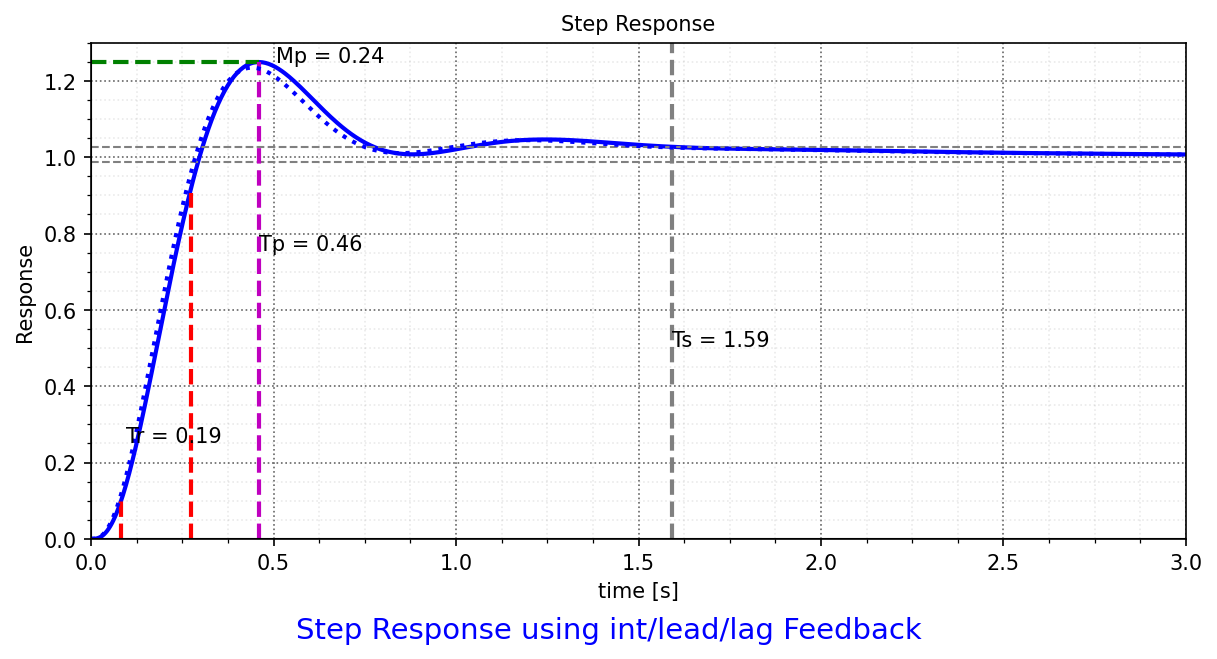

In [30]:
Gcl_full = feedback(L_full,1)
y_full,t_full = step(Gcl_full,3)

try: # was the iteration done?
    Gcl_full2 = feedback(L_full2,1)
    y_full2,t_full2 = step(Gcl_full2,3)
    iterated = True 
except:
    iterated = False 

fig, ax = plt.subplots(1,figsize=(8, 4),dpi=150,constrained_layout = True)
S_full = Step_info(t_full,y_full)
S_full.printout()
S_full.nice_plot(ax)
if iterated:
    plt.plot(t_full2,y_full2,'b:',label='Iteated')
nicegrid(ax,-1)
caption("Step Response using int/lead/lag Feedback",fig,yloc=-0.05)
savefig("./figs/L13_RL_des4.pdf", dpi=600)
plt.show()

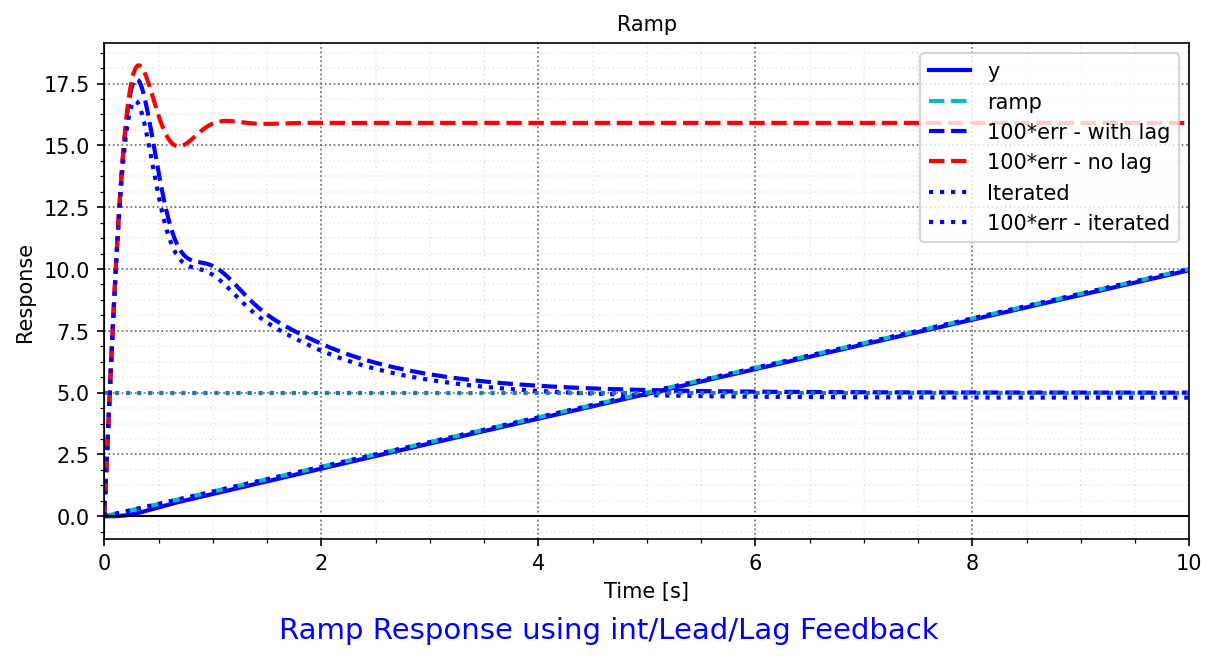

In [31]:
t = linspace(0,10,1000)
Gcl_IL = feedback(L_int_lead,1)
y_IL_ramp, t_IL_ramp, x_IL_ramp = lsim(Gcl_IL, T=t, U=t)
y_full_ramp, t_full_ramp, x_full_ramp = lsim(Gcl_full, T=t, U=t)

fig, ax = plt.subplots(figsize=(8, 4),dpi=150,constrained_layout = True)
plt.plot(t_full_ramp,y_full_ramp,'b-',label='y')
plt.plot(t_full_ramp,t_full_ramp,'c--',label='ramp')
plt.plot(t_full_ramp,100*(t_full_ramp - y_full_ramp),'b--',label='100*err - with lag')
plt.plot(t_IL_ramp,100*(t_IL_ramp - y_IL_ramp),'r--',label='100*err - no lag')
if iterated:
    y_full2_ramp, t_full2_ramp, x_full2_ramp = lsim(Gcl_full2, T=t, U=t)
    plt.plot(t_full2_ramp,t_full2_ramp,'b:',label='Iterated')
    plt.plot(t_full2_ramp,100*(t_full2_ramp - y_full2_ramp),'b:',label='100*err - iterated')
plt.axhline(y=100/Kv_req,ls=':')
nicegrid(ax,-1)
plt.title("Ramp")
plt.xlabel("Time [s]")
plt.ylabel("Response")
plt.legend()
caption("Ramp Response using int/Lead/Lag Feedback",fig,yloc=-0.05)
savefig("./figs/L13_RL_des5.pdf", dpi=600)
plt.show()